In this project I'm going to demonstrate how different machine learning algorithms perform on the task of classification of bug reprort summaries by the corresponding product components. At first let's import necessary dependencies:  

In [1]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from helpers import preprocess, print_roc_curve, plot_table, explore
from keras_neural_networks import KerasNeuralNetwork

Using TensorFlow backend.
/Users/stas/PycharmProjects/bugzilla-classifier/venv/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Now we will read dataset and explore its structure

In [2]:
df = pd.read_csv('bugs-2019-11-25.csv')
print(df.head())

    Bug ID                        Product       Component          Assignee  \
0  1408108                        Firefox            Sync  1991manish.kumar   
1  1417698                        Firefox  WebPayments UI              2042   
2   521116  Firefox for Android Graveyard       Bookmarks                21   
3   759911           Firefox OS Graveyard         General                21   
4   768939           Firefox OS Graveyard         General                21   

     Status Resolution                                            Summary  \
0  RESOLVED      FIXED  Rename "Sync ID" to "record ID" in the bookmar...   
1  RESOLVED      FIXED  Use mozilla recommended eslint rules and remov...   
2  RESOLVED      FIXED  showing "All bookmarks" from the awesomebar/au...   
3  RESOLVED      FIXED  include human readable build ID, version, and ...   
4  RESOLVED      FIXED  [settings][l10n]Setting locale in gaia setting...   

               Updated         Reporter platform-rel          

For training purpuses we will consider 'Summary', 'Reporter', 'Assignee', 'OS' columns as they contain the most valueble data. For target lables we will concatenate 'Product' and 'Component' columns. Also we will drop labels that have less than 50 occurencies.

In [3]:
df['target'] = df[['Product', 'Component']].apply(' -- '.join, axis=1)
df = df.groupby('target').filter(lambda x: len(x) > 50)
df['target'] = df['target'].astype('category')
df['target_labels'] = df['target'].cat.codes

Let's check that there are no missing bug summaries

In [4]:
print(f"Number of missing comments in comment text: {df['Summary'].isnull().sum()}")

Number of missing comments in comment text: 0


Now let's see the distibution of output categories in the whole dataset

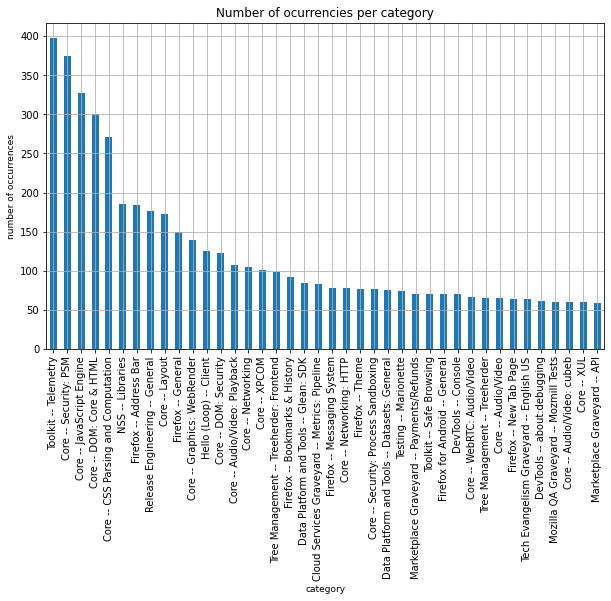

In [36]:
explore(df['target'], 40)

Let's preprocess the Summarry column by remove unwanted characters, stopwords and short words, make entire text lowercase

In [6]:
print(f"Summary column before preprocessing:\n{df['Summary'].head()}")
df['Summary'] = preprocess(df['Summary'])
print(f"Summary column after preprocessing:\n{df['Summary'].head()}")

Summary column before preprocessing:
3    include human readable build ID, version, and ...
4    [settings][l10n]Setting locale in gaia setting...
5    language.current should map to general.userage...
8    Send a system message to the application when ...
9    Use a system message when the application is c...
Name: Summary, dtype: object
Summary column after preprocessing:
3    include human readable build version channel d...
4    settings setting locale gaia settings app set ...
5    language current map general useragent locale ...
8    send system message application application ru...
9                use system message application closed
Name: Summary, dtype: object


Splitting dataset into train and test data

In [7]:
X = df[['Summary', 'Reporter', 'Assignee', 'OS']].apply(' '.join, axis=1)
y = df['target_labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)
print(f"Train dataset shape: {X_train.shape, y_train.shape}")
print(f"Test dataset shape: {X_test.shape, y_test.shape}")

Train dataset shape: ((4190,), (4190,))
Test dataset shape: ((1048,), (1048,))


Now we need to vectorize sentences in X dataset

In [8]:
# Initializing TfidfVectorizer
vectorizer = TfidfVectorizer()
# Vectorize the train dataset
X_train_vectors = vectorizer.fit_transform(X_train)
# Vectorize the testing dataset
X_test_vectors = vectorizer.transform(X_test)

When each sentense from X dataset is presented as a vector with tfidf weights, we can feed this vectorized dataset to different algorithms from sklearn library

In [9]:
# Train the Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train_vectors, y_train)
# Make predictions
predicted = nb.predict(X_test_vectors)
f1_score_nb = f1_score(y_test, predicted, average='micro')

# Train the SVM, optimized by Stochastic Gradient Descent
svm = SGDClassifier()
svm.fit(X_train_vectors, y_train)
predicted_svm = svm.predict(X_test_vectors)
f1_score_svm = f1_score(y_test, predicted_svm, average='micro')

# Train the Boosting classifier
boosting = GradientBoostingClassifier(n_estimators=100)
boosting.fit(X_train_vectors, y_train)
predicted = boosting.predict(X_test_vectors)
f1_score_boosting = f1_score(y_test, predicted, average='micro')

# Train the k-nearest neighbors classifier
knn = KNeighborsClassifier()
knn.fit(X_train_vectors, y_train)
predicted = knn.predict(X_test_vectors)
f1_score_knn = f1_score(y_test, predicted, average='micro')

# Train the Bagging classifier
bagging = BaggingClassifier(KNeighborsClassifier())
bagging.fit(X_train_vectors, y_train)
predicted = bagging.predict(X_test_vectors)
f1_score_bagging = f1_score(y_test, predicted, average='micro')

# Train the Decision Tree classifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_vectors, y_train)
predicted = decision_tree.predict(X_test_vectors)
f1_score_decision_tree = f1_score(y_test, predicted, average='micro')

# Train the Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train_vectors, y_train)
predicted = random_forest.predict(X_test_vectors)
f1_score_random_forest = f1_score(y_test, predicted, average='micro')

# Train the Multi-layer perceptron classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=400, activation='relu', solver='adam',
                    random_state=1, alpha=1e-5)
mlp.fit(X_train_vectors, y_train)
predicted = mlp.predict(X_test_vectors)
f1_score_MLP = f1_score(y_test, predicted, average='micro')

Now we can use keras library to train different neural networks. At first we build Word2Vec embeeding matrix and tokenize X dataset

In [10]:
neural_network = KerasNeuralNetwork(X_train, X_test)
embedding_matrix = neural_network.build_embedding_matrix()
X_train_nn_vectors, X_test_nn_vectors = neural_network.tokenize()

  0%|          | 0/5238 [00:00<?, ?it/s]

Building Word2Vec embeeding matrix


100%|██████████| 5238/5238 [00:00<00:00, 632387.22it/s]


Found 3962 word vectors


Let's train convolutional neural network with word embedding being learned from scratch with embedding layer

In [11]:
model_CNN = neural_network.build_CNN(X_train_nn_vectors.shape[1], y.values.max() + 1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
model_CNN.fit(X_train_nn_vectors, y_train, validation_data=(X_test_nn_vectors, y_test), epochs=7, batch_size=32,
              verbose=2, callbacks=[early_stop])
predicted = model_CNN.predict(X_test_nn_vectors)
predicted = np.argmax(predicted, axis=1)
f1_score_cnn = f1_score(y_test, predicted, average='micro')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 200)           20000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 39, 100)           40100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)             

/Users/stas/PycharmProjects/bugzilla-classifier/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4190 samples, validate on 1048 samples
Epoch 1/7
 - 81s - loss: 3.4786 - accuracy: 0.1876 - val_loss: 2.3015 - val_accuracy: 0.4313
Epoch 2/7
 - 72s - loss: 1.7401 - accuracy: 0.5265 - val_loss: 1.2232 - val_accuracy: 0.6221
Epoch 3/7
 - 70s - loss: 0.8348 - accuracy: 0.7420 - val_loss: 0.9031 - val_accuracy: 0.7395
Epoch 4/7
 - 75s - loss: 0.3680 - accuracy: 0.8890 - val_loss: 0.9974 - val_accuracy: 0.7557
Epoch 5/7
 - 90s - loss: 0.1405 - accuracy: 0.9544 - val_loss: 1.2200 - val_accuracy: 0.7538
Epoch 6/7
 - 100s - loss: 0.0574 - accuracy: 0.9823 - val_loss: 1.2935 - val_accuracy: 0.7538


In [12]:
# Train CNN with Word2Vec word vectors being updated through training
model_CNN_word2vec_trainable = neural_network.build_CNN(X_train_nn_vectors.shape[1], y.values.max() + 1,
                                                        word2vec_weights=embedding_matrix, trainable=True)
filepath_model_CNN_word2vec = "CNN_word2vec.{epoch:02d}-{val_accuracy:.4f}.hdf5"
model_CNN_word2vec_trainable.fit(X_train_nn_vectors, y_train, validation_data=(X_test_nn_vectors, y_test), epochs=6,
                                 batch_size=32, verbose=2, callbacks=[early_stop])
predicted = model_CNN_word2vec_trainable.predict(X_test_nn_vectors)
predicted = np.argmax(predicted, axis=1)
f1_score_cnn_word2vec_trainable = f1_score(y_test, predicted, average='micro')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 200)           20000000  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 39, 100)           40100     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)             

/Users/stas/PycharmProjects/bugzilla-classifier/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4190 samples, validate on 1048 samples
Epoch 1/6
 - 75s - loss: 2.5480 - accuracy: 0.4064 - val_loss: 1.2920 - val_accuracy: 0.5935
Epoch 2/6
 - 81s - loss: 1.1338 - accuracy: 0.6771 - val_loss: 0.9717 - val_accuracy: 0.7204
Epoch 3/6
 - 76s - loss: 0.8135 - accuracy: 0.7556 - val_loss: 0.9003 - val_accuracy: 0.7261
Epoch 4/6
 - 68s - loss: 0.6075 - accuracy: 0.8095 - val_loss: 0.8415 - val_accuracy: 0.7634
Epoch 5/6
 - 71s - loss: 0.4305 - accuracy: 0.8632 - val_loss: 0.9534 - val_accuracy: 0.7490
Epoch 6/6
 - 77s - loss: 0.3093 - accuracy: 0.8990 - val_loss: 1.0092 - val_accuracy: 0.7595


In [22]:
# Train CNN with static word vectors extracted from Word2Vec
model_CNN_word2vec_nontrainable = neural_network.build_CNN(X_train_nn_vectors.shape[1], y.values.max() + 1,
                                                           word2vec_weights=embedding_matrix, trainable=False)
model_CNN_word2vec_nontrainable.fit(X_train_nn_vectors, y_train, validation_data=(X_test_nn_vectors, y_test), epochs=5,
                                    batch_size=32, verbose=2, callbacks=[early_stop])
predicted = model_CNN_word2vec_nontrainable.predict(X_test_nn_vectors)
predicted = np.argmax(predicted, axis=1)
f1_score_cnn_word2vec_nontrainable = f1_score(y_test, predicted, average='micro')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 40, 200)           20000000  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 39, 100)           40100     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 100)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              103424    
_________________________________________________________________
dropout_26 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_27 (Dropout)         (None, 1024)            

In [14]:
# Train Long Short-Term Memory recurrent network
model_LSTM = neural_network.build_LSTM(y.values.max() + 1)
model_LSTM.fit(X_train_nn_vectors, y_train, validation_data=(X_test_nn_vectors, y_test), epochs=8, batch_size=32,
               verbose=2, callbacks=[early_stop])
predicted = model_LSTM.predict(X_test_nn_vectors)
predicted = np.argmax(predicted, axis=1)
f1_score_lstm = f1_score(y_test, predicted, average='micro')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 200)           20000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              205824    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 592)               606800    
Total params: 21,133,424
Trainable params: 21,133,424
Non-trainable params: 0
_________________________________________________________________


/Users/stas/PycharmProjects/bugzilla-classifier/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4190 samples, validate on 1048 samples
Epoch 1/8
 - 97s - loss: 3.9841 - accuracy: 0.0809 - val_loss: 3.3766 - val_accuracy: 0.1326
Epoch 2/8
 - 82s - loss: 2.6234 - accuracy: 0.3026 - val_loss: 1.7733 - val_accuracy: 0.4943
Epoch 3/8
 - 92s - loss: 1.4799 - accuracy: 0.5745 - val_loss: 1.1866 - val_accuracy: 0.6479
Epoch 4/8
 - 82s - loss: 0.8974 - accuracy: 0.7289 - val_loss: 1.0565 - val_accuracy: 0.7013
Epoch 5/8
 - 81s - loss: 0.5986 - accuracy: 0.8198 - val_loss: 0.9795 - val_accuracy: 0.7319
Epoch 6/8
 - 88s - loss: 0.3972 - accuracy: 0.8759 - val_loss: 1.0755 - val_accuracy: 0.7223
Epoch 7/8
 - 83s - loss: 0.2837 - accuracy: 0.9158 - val_loss: 1.1546 - val_accuracy: 0.7242


In [16]:
# Train deep neural network
model_DNN = neural_network.build_DNN(X_train_vectors.shape[1], y.values.max() + 1)
model_DNN.fit(X_train_vectors, y_train, validation_data=(X_test_vectors, y_test), epochs=6, batch_size=32, verbose=2,
              callbacks=[early_stop])
predicted = model_DNN.predict(X_test_vectors)
predicted = np.argmax(predicted, axis=1)
f1_score_dnn = f1_score(y_test, predicted, average='micro')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1024)              7788544   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)             

It is time to print the results. F1 Score is used as an accuracy metric. F1 score can be interpreted as a weighted average of the precision (True Positives/(True Positives + False Positives)) and recall (True Positives/(True Positives + False Negatives)). It is created by finding the harmonic mean of precision and recall. F1 = 2 * (precision * recall) / (precision + recall). Here is a table with f1 scores for all classifiers:

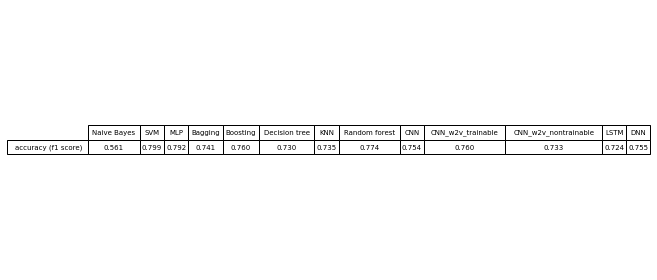

In [28]:
all_f1_scores = [f1_score_nb, f1_score_svm, f1_score_MLP, f1_score_bagging, f1_score_boosting, f1_score_decision_tree,
                 f1_score_knn, f1_score_random_forest, f1_score_cnn, f1_score_cnn_word2vec_trainable,
                 f1_score_cnn_word2vec_nontrainable, f1_score_lstm, f1_score_dnn]
column_names = ['Naive Bayes', 'SVM', 'MLP', 'Bagging', 'Boosting', 'Decision tree', 'KNN', 'Random forest', 'CNN',
                'CNN_w2v_trainable', 'CNN_w2v_nontrainable', 'LSTM', 'DNN']
plot_table(all_f1_scores, ['accuracy (f1 score)'], column_names)

Receiver operating characteristic (ROC) curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Here is ROC curves for all output classes of the best performing classifier:

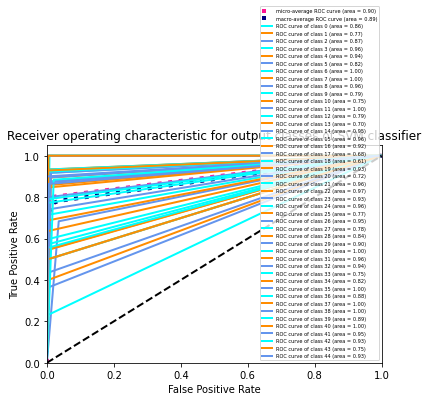

In [29]:
print_roc_curve(y_test=y_test, y_predicted=predicted_svm, number_of_classes=len(set(y)), title='SVM')

Here is classification report for the best performing classifier:

In [35]:
print(classification_report(y_test, predicted_svm, target_names=df['target'].cat.categories))

                                                        precision    recall  f1-score   support

         Cloud Services Graveyard -- Metrics: Pipeline       0.77      0.71      0.74        14
                                   Core -- Audio/Video       0.60      0.55      0.57        11
                         Core -- Audio/Video: Playback       0.80      0.74      0.77        27
                            Core -- Audio/Video: cubeb       0.85      0.92      0.88        12
                   Core -- CSS Parsing and Computation       0.81      0.89      0.85        57
                              Core -- DOM: Core & HTML       0.54      0.68      0.60        60
                                 Core -- DOM: Security       0.72      1.00      0.84        21
                           Core -- Graphics: WebRender       0.91      1.00      0.95        30
                             Core -- JavaScript Engine       0.90      0.93      0.92        59
                                       